##  Covid Image Classification Using ResNet and Inference
COVID-19 detection models utilizing CT images involve the application of machine learning algorithms to analyze chest X-ray images, aiming to identify patterns and features associated with COVID-19 infections. The provided [dataset](https://www.kaggle.com/datasets/plameneduardo/a-covid-multiclass-dataset-of-ct-scans/) comprises 4173 CT scan images of the lungs (Chest CT Scan) with three different classes, including Covid, Healthy, and Others.

### Download the Dataset

In [ ]:
from google.colab import files

In [ ]:
files.upload()

In [2]:
!pip install kaggle -q
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [3]:
!kaggle datasets download plameneduardo/a-covid-multiclass-dataset-of-ct-scans/

 99% 403M/405M [00:05<00:00, 109MB/s]
100% 405M/405M [00:05<00:00, 72.2MB/s]


In [4]:
!unzip ./a-covid-multiclass-dataset-of-ct-scans.zip

Archive:  ./a-covid-multiclass-dataset-of-ct-scans.zip
  inflating: New_Data_CoV2/Covid/Patient (10)/AnotaтАб╓╢o 2020-04-28 132320.png  
  inflating: New_Data_CoV2/Covid/Patient (10)/AnotaтАб╓╢o 2020-04-28 132449.png  
  inflating: New_Data_CoV2/Covid/Patient (10)/AnotaтАб╓╢o 2020-04-28 132516.png  
  inflating: New_Data_CoV2/Covid/Patient (10)/AnotaтАб╓╢o 2020-04-28 132540.png  
  inflating: New_Data_CoV2/Covid/Patient (10)/AnotaтАб╓╢o 2020-04-28 132608.png  
  inflating: New_Data_CoV2/Covid/Patient (10)/AnotaтАб╓╢o 2020-04-28 132636.png  
  inflating: New_Data_CoV2/Covid/Patient (10)/AnotaтАб╓╢o 2020-04-28 132704.png  
  inflating: New_Data_CoV2/Covid/Patient (10)/AnotaтАб╓╢o 2020-04-28 132740.png  
  inflating: New_Data_CoV2/Covid/Patient (10)/AnotaтАб╓╢o 2020-04-28 132814.png  
  inflating: New_Data_CoV2/Covid/Patient (10)/AnotaтАб╓╢o 2020-04-28 132844.png  
  inflating: New_Data_CoV2/Covid/Patient (10)/AnotaтАб╓╢o 2020-04-28 132926.png  
  inflating: New_Data_CoV2/Covid/Patient (1

### Preprocessing

In [5]:
import os
import shutil
import random
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
import cv2
import numpy as np
from sklearn import utils
import matplotlib.pyplot as plt
from skimage.util import random_noise
from skimage.filters import gaussian
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torch.optim import SGD
import tqdm
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torchvision.transforms as transforms
from torchvision import models
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np

In [6]:
!mkdir ./data
!mkdir ./data/train
!mkdir ./data/test
!mkdir ./data/train/covid
!mkdir ./data/train/healthy
!mkdir ./data/test/covid
!mkdir ./data/test/healthy

In [7]:
def copyfiles(source, dest):
    file_names = []
    for foldername, subfolders, filenames in os.walk(source):
        for filename in filenames:
            file_path = os.path.join(foldername, filename)
            file_names.append(file_path)

    train_files, test_files = train_test_split(file_names, test_size=0.2, random_state=42)
    for file_path in train_files:
        shutil.copy(file_path, os.path.join('./data/train' + dest, os.path.basename(file_path)))
    for file_path in test_files:
        shutil.copy(file_path, os.path.join('./data/test' + dest, os.path.basename(file_path)))

copyfiles('./New_Data_CoV2/Covid', '/covid')
copyfiles('./New_Data_CoV2/Healthy', '/healthy')

In [8]:
def count_files(directory_path):
    file_count = 0
    for root, dirs, files in os.walk(directory_path):
        file_count += len(files)
    return file_count

print('The total number of files in trainset:',  count_files('./data/train/'))
print('The total number of files in testset:',  count_files('./data/test/'))

The total number of files in trainset: 2057
The total number of files in testset: 537


Dataset visualizing.

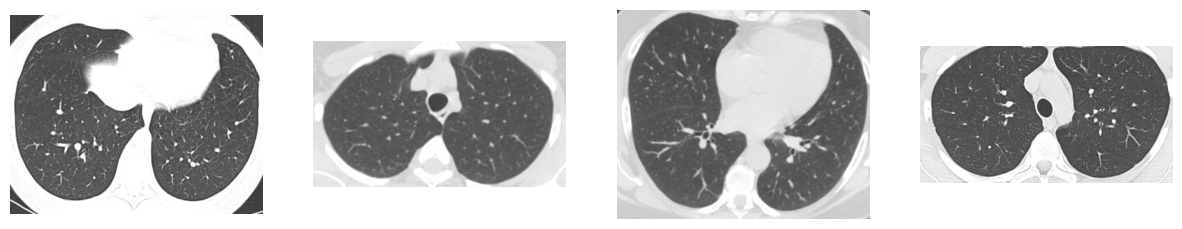

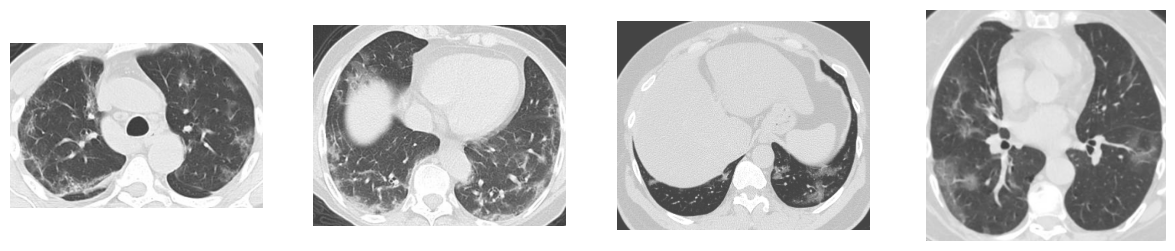

In [9]:
def plot_images_in_row(folder_path, num_images=4):
    image_files = [f for f in os.listdir(folder_path) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
    selected_images = random.sample(image_files, min(num_images, len(image_files)))
    plt.figure(figsize=(15, 3))

    for i, image_file in enumerate(selected_images, start=1):
        plt.subplot(1, num_images, i)
        image_path = os.path.join(folder_path, image_file)
        img = mpimg.imread(image_path)
        plt.imshow(img)
        plt.axis('off')

    plt.show()

covid_folder = './data/train/covid'
healthy_folder = './data/train/healthy'

plot_images_in_row(healthy_folder)
plot_images_in_row(covid_folder)

**Dataloader**

In [10]:
transform_train = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

transform_test = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

batch_size = 16

covid_train = os.listdir('./data/train/covid')
healthy_train = os.listdir('./data/train/healthy')

train_dataset = datasets.ImageFolder(root='./data/train', transform=transform_train)
test_dataset = datasets.ImageFolder(root='./data/test', transform=transform_test)

class_counts = [covid_train, healthy_train]
total_samples = sum(map(len, class_counts))
class_freq = [len(class_sample) / total_samples for class_sample in class_counts]

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=4)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


### ResNet

In [13]:
resnet_model = models.resnet18(pretrained=True)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

num_features = resnet_model.fc.in_features
resnet_model.fc = nn.Linear(num_features, 2)
resnet_model = resnet_model.to(device)

class_weights = torch.FloatTensor([1.0 / freq for freq in class_freq]).to(device)
criterion = torch.nn.CrossEntropyLoss(weight=class_weights)

optimizer = optim.Adam(resnet_model.parameters(), lr=0.0001)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 132MB/s]


In [ ]:
def fit_model(epochs, model, criterion, optimizer, Train, Test):

    train_acc, train_loss = [], []
    test_acc, test_loss = [], []

    for epoch in range(epochs):
        epoch_acc, epoch_loss = 0, 0
        model = model.train()

        with tqdm.tqdm(enumerate(Train), total=len(Train)) as pbar:
            for i, (images, labels) in pbar:
                images = images.to(device)
                labels = labels.to(device)

                output = model(images)
                optimizer.zero_grad()
                loss = criterion(output, labels)
                loss.backward()
                optimizer.step()

                epoch_loss += loss.detach().item()
                _, pred = output.data.topk(1, dim=1)
                epoch_acc += (pred.t() == labels).sum().item()

        train_loss.append(epoch_loss/(i+1))
        train_acc.append(epoch_acc/len(Train.dataset))

        print('Epoch: %d | Loss: %.4f | Train Accuracy: %.4f' \
          %(epoch, epoch_loss/(i+1), epoch_acc/len(Train.dataset)))

        epoch_acc, epoch_loss = 0, 0
        model.eval()

        with tqdm.tqdm(enumerate(Test), total=len(Test)) as pbar:
            for i, (images, labels) in pbar:
                images = images.to(device)
                labels = labels.to(device)

                output = model(images)
                loss = criterion(output, labels)

                epoch_loss += loss.detach().item()
                _, pred = output.data.topk(1, dim=1)

                epoch_acc += (pred.t() == labels).sum().item()

        test_loss.append(epoch_loss/(i+1))
        test_acc.append(epoch_acc/len(Test.dataset))

        print('Epoch: %d | Loss: %.4f | Test Accuracy: %.4f' \
          %(epoch, epoch_loss/(i+1), epoch_acc/len(Test.dataset)))

    return train_loss, train_acc, test_loss, test_acc


In [ ]:
epochs = 40
train_loss , train_acc, test_loss, test_acc = fit_model(epochs, resnet_model,
                                                        criterion, optimizer,
                                                        train_loader, test_loader)

100%|██████████| 64/64 [00:13<00:00,  4.86it/s]

Epoch: 0 | Loss: 0.2115 | Train Accuracy: 0.9047



100%|██████████| 17/17 [00:02<00:00,  7.15it/s]

Epoch: 0 | Loss: 0.1222 | Test Accuracy: 0.9465



100%|██████████| 64/64 [00:11<00:00,  5.49it/s]

Epoch: 1 | Loss: 0.0845 | Train Accuracy: 0.9697



100%|██████████| 17/17 [00:02<00:00,  5.82it/s]

Epoch: 1 | Loss: 0.1056 | Test Accuracy: 0.9576



100%|██████████| 64/64 [00:17<00:00,  3.74it/s]

Epoch: 2 | Loss: 0.0526 | Train Accuracy: 0.9775



100%|██████████| 17/17 [00:04<00:00,  4.12it/s]

Epoch: 2 | Loss: 0.0963 | Test Accuracy: 0.9613



100%|██████████| 64/64 [00:11<00:00,  5.55it/s]


Epoch: 3 | Loss: 0.0353 | Train Accuracy: 0.9883


100%|██████████| 17/17 [00:02<00:00,  6.95it/s]

Epoch: 3 | Loss: 0.1622 | Test Accuracy: 0.9465



100%|██████████| 64/64 [00:13<00:00,  4.90it/s]

Epoch: 4 | Loss: 0.0201 | Train Accuracy: 0.9932



100%|██████████| 17/17 [00:02<00:00,  7.08it/s]

Epoch: 4 | Loss: 0.0536 | Test Accuracy: 0.9779



100%|██████████| 64/64 [00:11<00:00,  5.56it/s]


Epoch: 5 | Loss: 0.0212 | Train Accuracy: 0.9946


100%|██████████| 17/17 [00:02<00:00,  7.19it/s]


Epoch: 5 | Loss: 0.0653 | Test Accuracy: 0.9779


100%|██████████| 64/64 [00:11<00:00,  5.69it/s]


Epoch: 6 | Loss: 0.0154 | Train Accuracy: 0.9951


100%|██████████| 17/17 [00:02<00:00,  7.19it/s]

Epoch: 6 | Loss: 0.0581 | Test Accuracy: 0.9705



100%|██████████| 64/64 [00:15<00:00,  4.25it/s]


Epoch: 7 | Loss: 0.0275 | Train Accuracy: 0.9902


100%|██████████| 17/17 [00:03<00:00,  5.10it/s]

Epoch: 7 | Loss: 0.0632 | Test Accuracy: 0.9779



100%|██████████| 64/64 [00:14<00:00,  4.32it/s]

Epoch: 8 | Loss: 0.0088 | Train Accuracy: 0.9980



100%|██████████| 17/17 [00:04<00:00,  3.48it/s]

Epoch: 8 | Loss: 0.0203 | Test Accuracy: 0.9908



100%|██████████| 64/64 [00:16<00:00,  3.89it/s]

Epoch: 9 | Loss: 0.0056 | Train Accuracy: 0.9980



100%|██████████| 17/17 [00:02<00:00,  5.85it/s]

Epoch: 9 | Loss: 0.0310 | Test Accuracy: 0.9834



100%|██████████| 64/64 [00:11<00:00,  5.51it/s]

Epoch: 10 | Loss: 0.0115 | Train Accuracy: 0.9956



100%|██████████| 17/17 [00:02<00:00,  7.15it/s]

Epoch: 10 | Loss: 0.0639 | Test Accuracy: 0.9797



100%|██████████| 64/64 [00:11<00:00,  5.43it/s]

Epoch: 11 | Loss: 0.0089 | Train Accuracy: 0.9976



100%|██████████| 17/17 [00:02<00:00,  7.03it/s]

Epoch: 11 | Loss: 0.0694 | Test Accuracy: 0.9742



100%|██████████| 64/64 [00:11<00:00,  5.46it/s]

Epoch: 12 | Loss: 0.0033 | Train Accuracy: 0.9995



100%|██████████| 17/17 [00:02<00:00,  7.09it/s]

Epoch: 12 | Loss: 0.0459 | Test Accuracy: 0.9852



100%|██████████| 64/64 [00:11<00:00,  5.50it/s]

Epoch: 13 | Loss: 0.0048 | Train Accuracy: 0.9985



100%|██████████| 17/17 [00:02<00:00,  7.06it/s]

Epoch: 13 | Loss: 0.0903 | Test Accuracy: 0.9834



100%|██████████| 64/64 [00:12<00:00,  5.31it/s]

Epoch: 14 | Loss: 0.0074 | Train Accuracy: 0.9966



100%|██████████| 17/17 [00:02<00:00,  7.02it/s]

Epoch: 14 | Loss: 0.1046 | Test Accuracy: 0.9686



100%|██████████| 64/64 [00:11<00:00,  5.52it/s]

Epoch: 15 | Loss: 0.0111 | Train Accuracy: 0.9971



100%|██████████| 17/17 [00:02<00:00,  7.09it/s]

Epoch: 15 | Loss: 0.1442 | Test Accuracy: 0.9686



100%|██████████| 64/64 [00:11<00:00,  5.52it/s]

Epoch: 16 | Loss: 0.0093 | Train Accuracy: 0.9961



100%|██████████| 17/17 [00:02<00:00,  6.98it/s]

Epoch: 16 | Loss: 0.0685 | Test Accuracy: 0.9815



100%|██████████| 64/64 [00:11<00:00,  5.49it/s]

Epoch: 17 | Loss: 0.0217 | Train Accuracy: 0.9941



100%|██████████| 17/17 [00:02<00:00,  6.98it/s]

Epoch: 17 | Loss: 0.0423 | Test Accuracy: 0.9852



100%|██████████| 64/64 [00:13<00:00,  4.60it/s]

Epoch: 18 | Loss: 0.0114 | Train Accuracy: 0.9956



100%|██████████| 17/17 [00:02<00:00,  6.93it/s]

Epoch: 18 | Loss: 0.0884 | Test Accuracy: 0.9797



100%|██████████| 64/64 [00:11<00:00,  5.45it/s]

Epoch: 19 | Loss: 0.0053 | Train Accuracy: 0.9980



100%|██████████| 17/17 [00:02<00:00,  7.09it/s]

Epoch: 19 | Loss: 0.0455 | Test Accuracy: 0.9852



100%|██████████| 64/64 [00:11<00:00,  5.49it/s]

Epoch: 20 | Loss: 0.0024 | Train Accuracy: 0.9995



100%|██████████| 17/17 [00:02<00:00,  6.78it/s]

Epoch: 20 | Loss: 0.0369 | Test Accuracy: 0.9834



100%|██████████| 64/64 [00:11<00:00,  5.58it/s]

Epoch: 21 | Loss: 0.0038 | Train Accuracy: 0.9980



100%|██████████| 17/17 [00:03<00:00,  5.45it/s]

Epoch: 21 | Loss: 0.0418 | Test Accuracy: 0.9815



100%|██████████| 64/64 [00:12<00:00,  5.14it/s]

Epoch: 22 | Loss: 0.0029 | Train Accuracy: 0.9990



100%|██████████| 17/17 [00:03<00:00,  4.95it/s]

Epoch: 22 | Loss: 0.0189 | Test Accuracy: 0.9926



100%|██████████| 64/64 [00:11<00:00,  5.81it/s]


Epoch: 23 | Loss: 0.0014 | Train Accuracy: 0.9995


100%|██████████| 17/17 [00:02<00:00,  5.79it/s]

Epoch: 23 | Loss: 0.0419 | Test Accuracy: 0.9852



100%|██████████| 64/64 [00:10<00:00,  5.88it/s]

Epoch: 24 | Loss: 0.0101 | Train Accuracy: 0.9976



100%|██████████| 17/17 [00:02<00:00,  5.93it/s]

Epoch: 24 | Loss: 0.0681 | Test Accuracy: 0.9815



100%|██████████| 64/64 [00:10<00:00,  5.86it/s]

Epoch: 25 | Loss: 0.0133 | Train Accuracy: 0.9951



100%|██████████| 17/17 [00:03<00:00,  4.32it/s]

Epoch: 25 | Loss: 0.1043 | Test Accuracy: 0.9723



100%|██████████| 64/64 [00:11<00:00,  5.58it/s]

Epoch: 26 | Loss: 0.0021 | Train Accuracy: 1.0000



100%|██████████| 17/17 [00:02<00:00,  7.06it/s]

Epoch: 26 | Loss: 0.0353 | Test Accuracy: 0.9889



100%|██████████| 64/64 [00:11<00:00,  5.51it/s]

Epoch: 27 | Loss: 0.0016 | Train Accuracy: 0.9995



100%|██████████| 17/17 [00:02<00:00,  7.15it/s]

Epoch: 27 | Loss: 0.0287 | Test Accuracy: 0.9852



100%|██████████| 64/64 [00:11<00:00,  5.51it/s]

Epoch: 28 | Loss: 0.0008 | Train Accuracy: 1.0000



100%|██████████| 17/17 [00:02<00:00,  7.03it/s]

Epoch: 28 | Loss: 0.0481 | Test Accuracy: 0.9834



100%|██████████| 64/64 [00:11<00:00,  5.45it/s]

Epoch: 29 | Loss: 0.0029 | Train Accuracy: 0.9995



100%|██████████| 17/17 [00:02<00:00,  6.86it/s]

Epoch: 29 | Loss: 0.0418 | Test Accuracy: 0.9834



100%|██████████| 64/64 [00:11<00:00,  5.45it/s]

Epoch: 30 | Loss: 0.0032 | Train Accuracy: 0.9990



100%|██████████| 17/17 [00:02<00:00,  7.11it/s]

Epoch: 30 | Loss: 0.0437 | Test Accuracy: 0.9815



100%|██████████| 64/64 [00:11<00:00,  5.50it/s]

Epoch: 31 | Loss: 0.0061 | Train Accuracy: 0.9990



100%|██████████| 17/17 [00:02<00:00,  6.87it/s]

Epoch: 31 | Loss: 0.0610 | Test Accuracy: 0.9852



100%|██████████| 64/64 [00:11<00:00,  5.48it/s]

Epoch: 32 | Loss: 0.0193 | Train Accuracy: 0.9941



100%|██████████| 17/17 [00:02<00:00,  7.18it/s]

Epoch: 32 | Loss: 0.0304 | Test Accuracy: 0.9852



100%|██████████| 64/64 [00:11<00:00,  5.48it/s]

Epoch: 33 | Loss: 0.0171 | Train Accuracy: 0.9941



100%|██████████| 17/17 [00:02<00:00,  7.16it/s]

Epoch: 33 | Loss: 0.1603 | Test Accuracy: 0.9594



100%|██████████| 64/64 [00:11<00:00,  5.44it/s]

Epoch: 34 | Loss: 0.0163 | Train Accuracy: 0.9941



100%|██████████| 17/17 [00:02<00:00,  6.97it/s]

Epoch: 34 | Loss: 0.0543 | Test Accuracy: 0.9852



100%|██████████| 64/64 [00:11<00:00,  5.43it/s]

Epoch: 35 | Loss: 0.0030 | Train Accuracy: 0.9995



100%|██████████| 17/17 [00:02<00:00,  7.01it/s]

Epoch: 35 | Loss: 0.0339 | Test Accuracy: 0.9908



100%|██████████| 64/64 [00:11<00:00,  5.44it/s]

Epoch: 36 | Loss: 0.0072 | Train Accuracy: 0.9971



100%|██████████| 17/17 [00:02<00:00,  6.98it/s]

Epoch: 36 | Loss: 0.0916 | Test Accuracy: 0.9797



100%|██████████| 64/64 [00:11<00:00,  5.53it/s]

Epoch: 37 | Loss: 0.0082 | Train Accuracy: 0.9980



100%|██████████| 17/17 [00:02<00:00,  7.03it/s]

Epoch: 37 | Loss: 0.0432 | Test Accuracy: 0.9852



100%|██████████| 64/64 [00:11<00:00,  5.38it/s]

Epoch: 38 | Loss: 0.0010 | Train Accuracy: 1.0000



100%|██████████| 17/17 [00:02<00:00,  5.77it/s]

Epoch: 38 | Loss: 0.0347 | Test Accuracy: 0.9908



100%|██████████| 64/64 [00:12<00:00,  5.23it/s]

Epoch: 39 | Loss: 0.0004 | Train Accuracy: 1.0000



100%|██████████| 17/17 [00:02<00:00,  7.00it/s]

Epoch: 39 | Loss: 0.0251 | Test Accuracy: 0.9871


Accuracy and Loss plots for both training and validation parts.

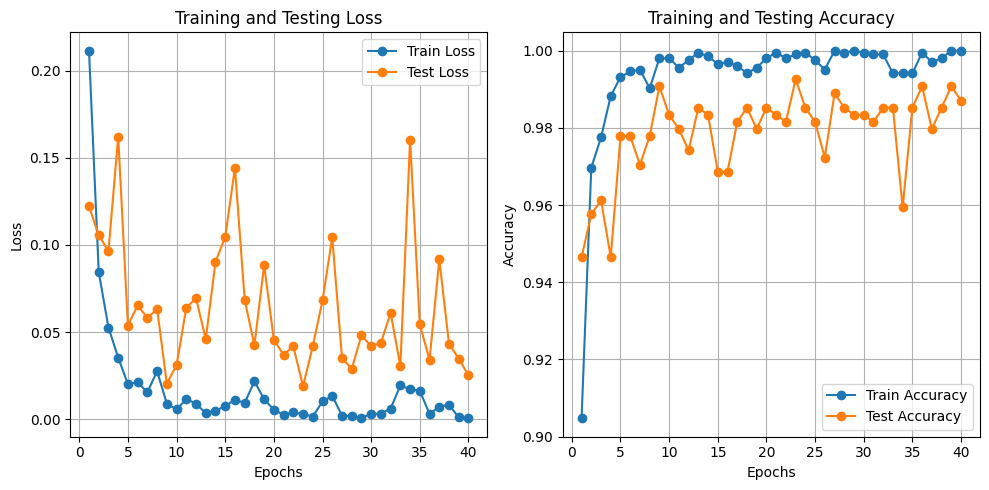

In [ ]:
epochs = range(1, epochs + 1)
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs, train_loss, label='Train Loss', marker='o')
plt.plot(epochs, test_loss, label='Test Loss', marker='o')
plt.title('Training and Testing Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(epochs, train_acc, label='Train Accuracy', marker='o')
plt.plot(epochs, test_acc, label='Test Accuracy', marker='o')
plt.title('Training and Testing Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

### Interpretability
Here, we aim to select an interpretability algorithm that aids in comprehending the model's decision-making process, debugging, and explaining predictions to non-technical stakeholders. Let's opt for the [Grad-CAM](https://arxiv.org/abs/1610.02391) technique. Grad-CAM, short for Gradient-weighted Class Activation Mapping, highlights important regions in an image that contribute to the model's prediction. This is achieved by computing the gradients of the target class with respect to the final convolutional layer.

[GradCam github](https://github.com/jacobgil/pytorch-grad-cam)

GradCAM use gradient information following into last convolutional layer to assign importance to each neurons for given class. First, it computes gradient of the score for class c, $y^c$ (before softmax), based on feature map activation function $A^k$ i.e. ($\frac{\partial y^c}{\partial A^k} $).

Using this gradient it generates weights for each $A^k$. Having these weights it performes a weigheted combination on feature map follow with a ReLU to remove negative values (discriminative features for other classes). The final importance matrix will be obtain by:

$L_{Grad-CAM}^{c} =ReLU\left(\sum _{k} \alpha _{k}^{c} A^{k}\right)$

This result is a coarse heatmap of the same size as the last convolutional feature maps.

In [ ]:
# import copy
# torch.save(copy.deepcopy(resnet_model.state_dict()), '/content/drive/MyDrive/CurrentData/gradCam.pt')

In [14]:
# resnet_model.load_state_dict(torch.load('/content/drive/MyDrive/CurrentData/gradCam.pt', map_location=torch.device('cpu')))

<All keys matched successfully>

In [15]:
'''
  Initially, it is crucial to ensure that the model is in Evaluation mode.
  Failing to do so during result verification could inadvertently alter the
  model's weights, leading to inaccurate and unreliable results.
'''
resnet_model.eval()
device = "cpu"
resnet_model.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [ ]:
!pip install grad-cam -q

In [17]:
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.image import show_cam_on_image

In [ ]:
def plot_GradCam(image_path, state):

    input_tensor = transform_test(Image.open(image_path).convert('RGB')).unsqueeze(0)

    target_layers = [resnet_model.layer4[-1]]
    cam = GradCAM(model=resnet_model, target_layers=target_layers)
    grayscale_cam = cam(input_tensor=input_tensor,  aug_smooth=True, eigen_smooth=True)
    grayscale_cam = grayscale_cam[0, :]
    visualization = show_cam_on_image(input_tensor.squeeze(0).permute(1,2,0).numpy(), grayscale_cam, use_rgb=True)

    fig, axes = plt.subplots(1, 2, figsize=(12, 6))
    fig.suptitle(state)

    axes[0].imshow(input_tensor.squeeze(0).permute(1,2,0).numpy())
    axes[0].set_title("Image")
    axes[1].imshow(visualization)
    axes[1].set_title("GradCAM")

Visualizing GradCAM heatmaps for 10 images.

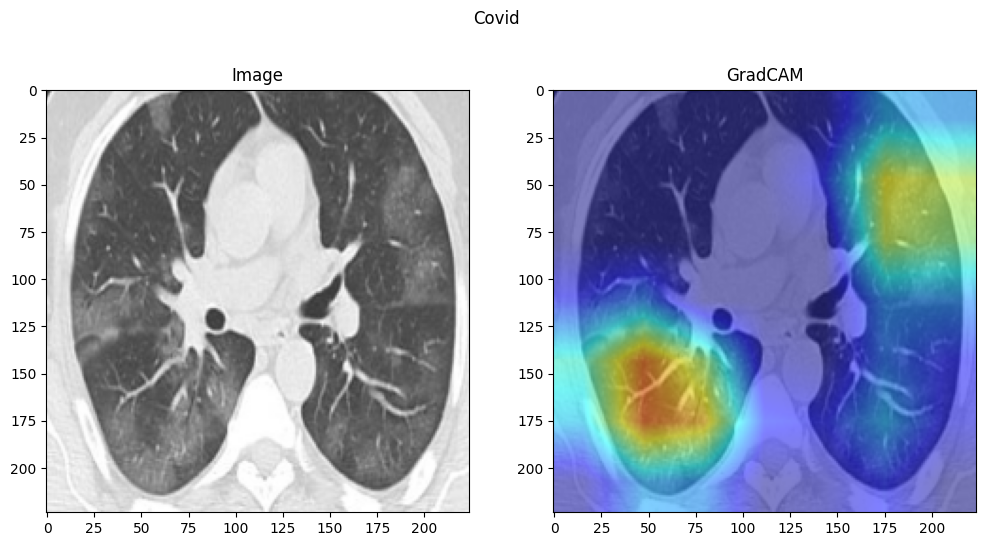

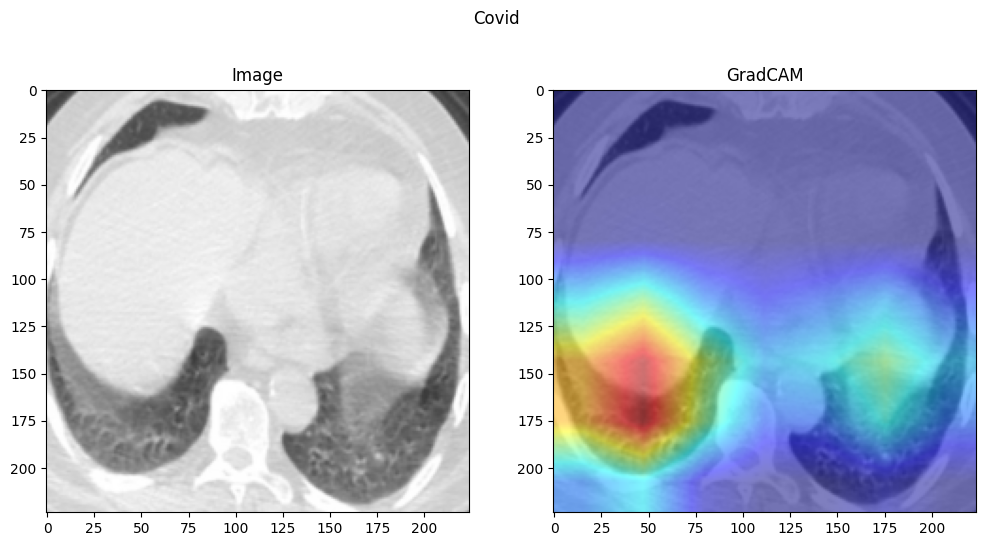

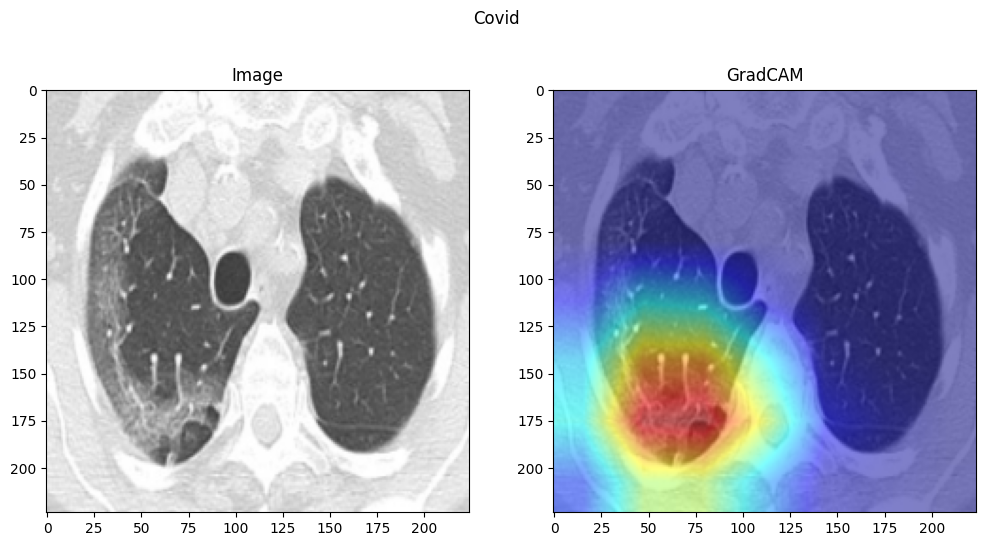

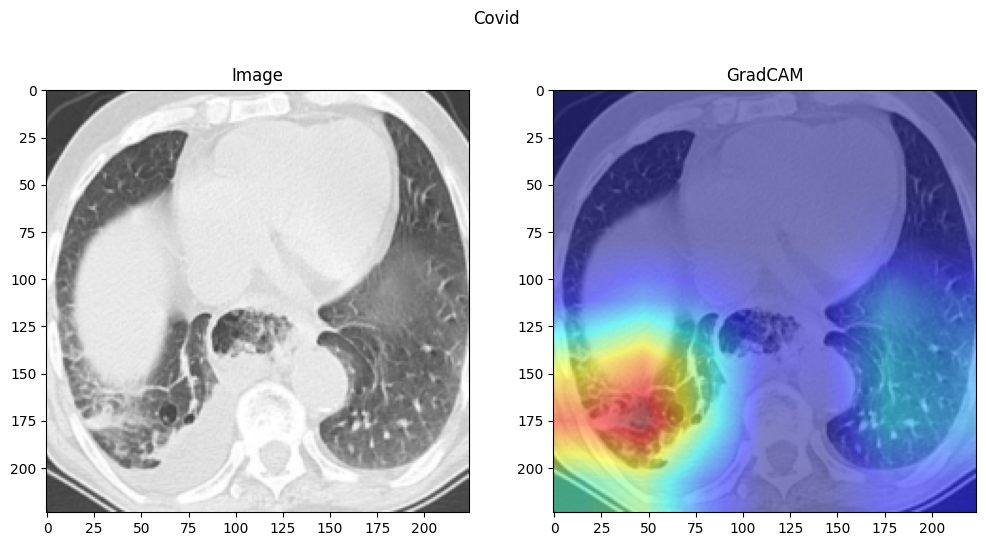

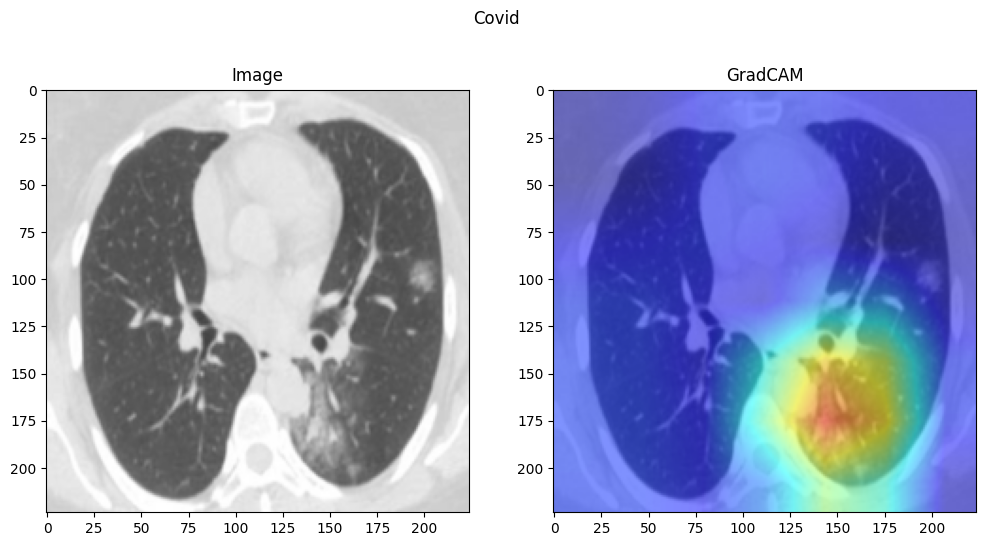

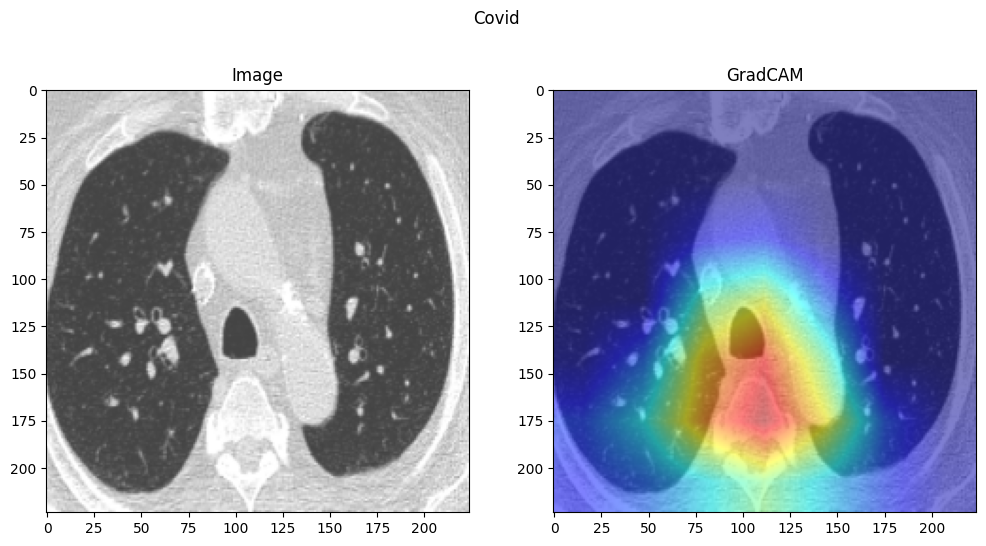

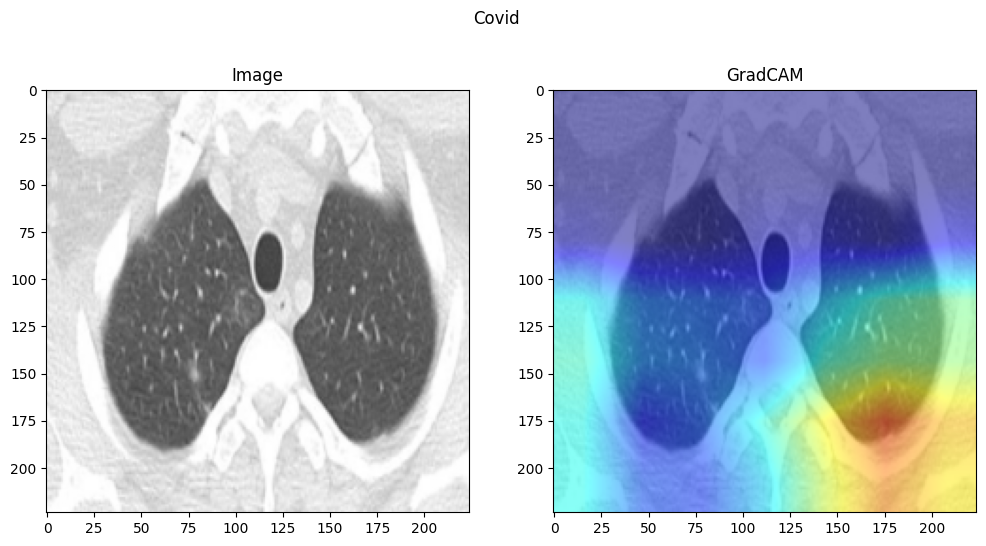

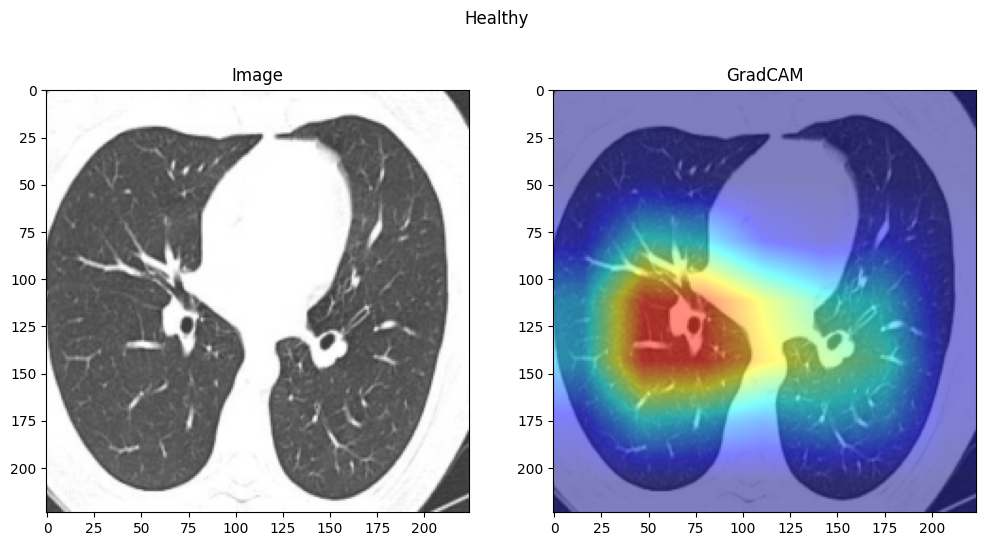

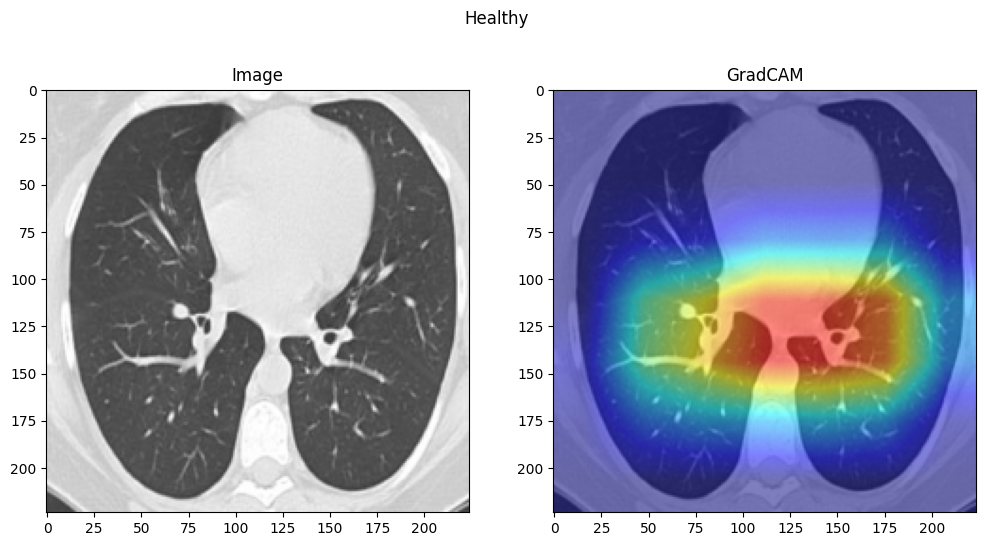

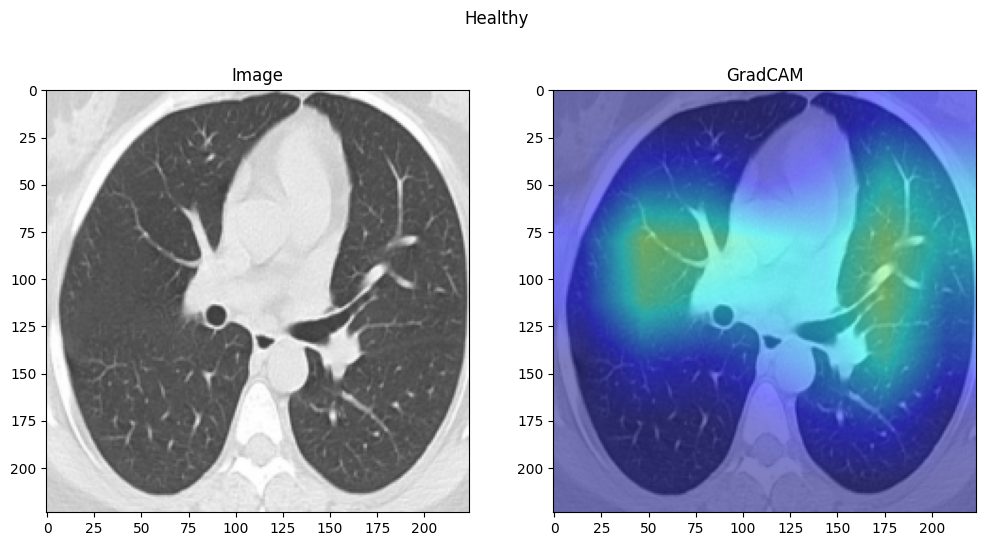

In [23]:
root_covid = '/content/data/test/covid'
root_healthy = '/content/data/test/healthy'

random_covid_images = np.random.choice(os.listdir(root_covid), size=7)
for img in random_covid_images:
  plot_GradCam(f'{root_covid}/{img}', 'Covid')

random_healthy_images = np.random.choice(os.listdir(root_healthy), size=3)
for img in random_healthy_images:
  plot_GradCam(f'{root_healthy}/{img}', 'Healthy')